### 2.1 Image Based Input 
    - https://arxiv.org/pdf/2408.03292

In addition to the above 3 image-based inputs, a spice file is used to describe detailed information across each individual metal and via layer. The spice file contains:

- Locations of PDN nodes
- Values of resistances between nodes
- Current source nodes and their values
- Voltage source nodes

### Image Extraction Process

We extract multiple image-based files from this single spice file, where each new file corresponds to the data of a specific metal or via layer. These files are encoded in a similar matrix format where:

- Each entry (pixel) represents a lumped resistance in area.

### Extracted Image-Based Files

For the ICCAD 2023 contest setup, we extract image-based files corresponding to resistances of the following layers:

- **Metal Layers:**
- M1
- M4
- M7
- M8
- M9
- **Via Layers:**
- M14
- M47
- M78
- M89


    

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import gzip
import glob

In [15]:
# 1. SPICE 파일 읽기 함수
def parse_spice_file(file_path, target_layers):
    via_layer_map = {
        ('m1', 'm4'): 'm14',
        ('m4', 'm7'): 'm47',
        ('m7', 'm8'): 'm78',
        ('m8', 'm9'): 'm89'
    }
    # Initialize layer data for both target layers and via layers
    all_layers = target_layers + list(via_layer_map.values())
    layer_data = {layer: [] for layer in all_layers}
    
    open_func = gzip.open if file_path.endswith('.gz') else open
    mode = 'rt' if file_path.endswith('.gz') else 'r'

    with open_func(file_path, mode) as file:
        for line in file:
            # Match resistance lines with format like: R645 n1_m1_108000_17920 n1_m1_102600_179200 0.14
            match = re.match(r"R\d+\s+n1_(\w+)_(\d+)_(\d+)\s+n1_(\w+)_(\d+)_(\d+)\s+([\d.]+)", line, re.IGNORECASE)

            if match:
                layer1 = match.group(1).lower()  # Convert to lowercase for consistency
                layer2 = match.group(4).lower()  # Convert to lowercase for consistency
                x1, y1 = int(match.group(2)), int(match.group(3))
                x2, y2 = int(match.group(5)), int(match.group(6))
                resistance = float(match.group(7))

                
                if layer1 in target_layers and layer2 in target_layers and layer1 == layer2:
                    # Case for metal layers
                    layer_data[layer1].append(((x1, y1), (x2, y2), resistance))
                elif layer1 in target_layers and layer2 in target_layers:
                    # Case for via layers (e.g., M14, M47)
                    via_layer = via_layer_map.get((layer1, layer2)) or via_layer_map.get((layer2, layer1))
                    if via_layer:
                        layer_data[via_layer].append(((x1, y1), (x2, y2), resistance))

    return layer_data

# 2. CSV 파일 크기 읽기 함수
def get_csv_matrix_size(file_path):
    """
    Reads a compressed (.gz) CSV file and returns the size of the matrix.
    
    Args:
    - file_path: Path to the CSV file.
    
    Returns:
    - Tuple containing the number of rows and columns (height, width).
    """
    open_func = gzip.open if file_path.endswith('.gz') else open
    
    with open_func(file_path, 'rt') as f:
        matrix = pd.read_csv(f, header=None)
        
    return matrix.shape  # Returns (height, width)

# Function to convert coordinates to matrix indices and fill matrix with resistance values
def convert_to_matrix_indices(layer_resistances, matrix_size=(100,100)):
    matrix = np.zeros((matrix_size[0], matrix_size[1]))
    
    for (x1, y1), (x2, y2), resistance in layer_resistances:
        # Convert from nanometers to micrometers (assuming coordinates are in nanometers)
        # debug
        x1, y1 = x1 // 2000, y1 // 2000
        x2, y2 = x2 // 2000, y2 // 2000
        
        # Ensure indices are within matrix bounds
        if 0 <= x1 < matrix_size[1] and 0 <= y1 < matrix_size[0]:
            matrix[x1, y1] += resistance
        if 0 <= x2 < matrix_size[1] and 0 <= y2 < matrix_size[0]:
            matrix[x2, y2] += resistance
    
    return matrix

# 6. 이미지 저장 함수
def save_matrix_as_image(matrix, layer, output_dir):
    """
    Saves the resistance matrix as a heatmap image.
    
    Args:
    - matrix: 2D numpy array representing the resistance matrix.
    - layer: String representing the layer name.
    - output_dir: Directory where the images will be saved.
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(matrix, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Resistance (ohms)')
    plt.title(f'Resistance Map for {layer.upper()}')
    
    output_image_path = os.path.join(output_dir, f'{layer}_resistance_map.png')
    plt.savefig(output_image_path)
    plt.close()

def visualize_layer_matrix(matrix, layer_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, cmap="viridis", cbar=True)
    plt.title(f"Layer {layer_name} Resistance Matrix Visualization")
    plt.xlabel("X-coordinate (µm)")
    plt.ylabel("Y-coordinate (µm)")
    plt.show()

def save_matrix_as_image(matrix, layer, output_dir):
    """
    Saves the resistance matrix as a heatmap image.
    
    Args:
    - matrix: 2D numpy array representing the resistance matrix.
    - layer: String representing the layer name.
    - output_dir: Directory where the images will be saved.
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(matrix, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Resistance (ohms)')
    plt.title(f'Resistance Map for {layer.upper()}')
    
    # Save the image
    output_image_path = os.path.join(output_dir, f'{layer}_resistance_map.png')
    plt.savefig(output_image_path)
    plt.close()

def save_matrix_as_npy(matrix, layer, current_map_number, output_dir,unzip_mode):
    os.makedirs(output_dir, exist_ok=True)
    file_name = f'current_map{current_map_number:02d}_m{layer[1:]}_resistance.npy' if not unzip_mode else f'current_map{current_map_number:04d}_m{layer[1:]}_resistance.npy'
    output_file_path = os.path.join(output_dir, file_name)
    np.save(output_file_path, matrix)
    
# 7. 전체 프로세스 실행 함수
# Modified process_spice_file function to save as .npy
def process_spice_file(file_path, target_layers, csv_files, output_dir='layer_data'):
    """
    Full process for reading a SPICE file, extracting layer data, creating resistance matrices, and saving them as .npy files.
    
    Args:
    - file_path: Path to the SPICE file.
    - target_layers: List of metal and via layers to extract.
    - csv_files: Dictionary containing file paths of the CSV files (current, pdn_density, eff_dist).
    - output_dir: Directory where the .npy files will be saved.
    """
    # Step 1: SPICE 파일 읽기
    layer_data = parse_spice_file(file_path, target_layers=target_layers)
    
    # Step 2: CSV 파일에서 매트릭스 크기 추출
    resolution = get_csv_matrix_size(csv_files['current_map'])
    # resolution = max(resolution[0], resolution[1])
    
    # 출력 디렉토리 생성
    os.makedirs(output_dir, exist_ok=True)
    
    for layer in target_layers:
        resistance_matrix = convert_to_matrix_indices(layer_data[layer], matrix_size=resolution)
        
        # Save as .npy file
        output_file_path = os.path.join(output_dir, f'{layer}_resistance_matrix.npy')
        np.save(output_file_path, resistance_matrix)
        # plt.imshow(resistance_matrix)
        # plt.show()
    print(f"Process completed. .npy files are saved in {output_dir}.")

# # 실행 예시
# root = '/data/ICCAD_2023/real-circuit-data_20230615/testcase11'
# csv_files = {
#     'current_map': os.path.join(root,'current_map.csv'),
#     'pdn_density': os.path.join(root,'pdn_density.csv'),
#     'eff_dist': os.path.join(root,'eff_dist_map.csv')
# }

# target_layers = ['m1', 'm4', 'm7', 'm8', 'm9', 'm14', 'm47', 'm78', 'm89']
# file_path = os.path.join(root, 'netlist.sp')

# process_spice_file(file_path, target_layers, csv_files, output_dir='layers2')

# New function to process all testcases
def process_all_testcases(root_dir):
    testcase_dirs = [d for d in os.listdir(root_dir) if d.startswith('testcase')]
    
    for testcase in testcase_dirs:
        print(f"Processing {testcase}...")
        testcase_path = os.path.join(root_dir, testcase)
        
        csv_files = {
            'current_map': os.path.join(testcase_path, 'current_map.csv'),
            'pdn_density': os.path.join(testcase_path, 'pdn_density.csv'),
            'eff_dist': os.path.join(testcase_path, 'eff_dist_map.csv')
        }
        
        target_layers = ['m1', 'm4', 'm7', 'm8', 'm9', 'm14', 'm47', 'm78', 'm89']
        file_path = os.path.join(testcase_path, 'netlist.sp')
        output_dir = os.path.join(testcase_path, 'layer_data')
        
        process_spice_file(file_path, target_layers, csv_files, output_dir)



In [3]:
# Execute the process for all testcases
# Done
# root_dir = '/data/ICCAD_2023/real-circuit-data_20230615'
# process_all_testcases(root_dir)
# root_dir = '/data/ICCAD_2023/hidden-real-circuit-data'
# process_all_testcases(root_dir)


In [16]:
# 5. 전체 폴더 내 모든 SPICE 파일 처리 함수
def process_all_sp_files(root_dir, output_dir):
    sp_files = [f for f in os.listdir(root_dir) if f.endswith('.sp') or f.endswith('.sp.gz')]
    
    target_layers = ['m1', 'm4', 'm7', 'm8', 'm9', 'm14', 'm47', 'm78', 'm89']
    
    for sp_file in sp_files:
        # Extract prefix from the SPICE file name
        prefix = sp_file.split('_')[0]
        
        # Find matching CSV files for the prefix
        csv_files = {
            'current_map': glob.glob(os.path.join(root_dir, f"{prefix}*current*.csv.gz"))[0],
        }

        # Check if all required CSV files exist
        if not all(os.path.exists(csv_file) for csv_file in csv_files.values()):
            print(f"Warning: Not all CSV files found for prefix {sp_file}. Skipping...")
            continue

        sp_file_path = os.path.join(root_dir, sp_file)
        print(f"Processing {sp_file} with CSV files {csv_files}...")
        
        # Set output directory path specific to each SPICE file
        file_output_dir = os.path.join(output_dir, prefix)
        
        # Process the SPICE file with the matching CSV files and resolution
        process_spice_file(sp_file_path, target_layers, csv_files=csv_files, output_dir=file_output_dir)

# 6. 실행 예시
# root_dir = '/data/real-circuit-benchmarks/nangate45/data'
# output_dir = '/data/real-circuit-benchmarks/nangate45/numpy_data/layer_data'

# process_all_sp_files(root_dir, output_dir)


In [5]:
import os
import glob

# 5. 전체 폴더 내 모든 SPICE 파일 처리 함수
def process_all_sp_files_asap7(root_dir, output_dir):
    # List all SPICE files in the directory
    sp_files = [f for f in os.listdir(root_dir) if f.endswith('.sp') or f.endswith('.sp.gz')]
    
    # Target layers to process
    target_layers = ['m1', 'm4', 'm7', 'm8', 'm9', 'm14', 'm47', 'm78', 'm89']
    
    # Process each SPICE file separately
    for sp_file in sp_files:
        # Extract prefix and grid type (irreg or reg) from the SPICE file name
        parts = sp_file.split('_')
        prefix = parts[0]
        grid_type = 'irreg' if 'irreg' in parts else 'reg'

        if prefix in 'dynamic_node':
            prefix = 'dynamic_node'
        
        # Define patterns to locate each relevant CSV file for the current prefix
        csv_files = {
            'current_map': glob.glob(os.path.join(root_dir, f"{prefix}_current_map.csv.gz")),
            'voltage_map_irregular': glob.glob(os.path.join(root_dir, f"{prefix}_voltage_map_irregular.csv.gz")),
            'voltage_map_regular': glob.glob(os.path.join(root_dir, f"{prefix}_voltage_map_regular.csv.gz")),
            'irreg_grid': glob.glob(os.path.join(root_dir, f"{prefix}_irreg_grid.sp.gz")),
            'reg_grid': glob.glob(os.path.join(root_dir, f"{prefix}_reg_grid.sp.gz"))
        }

        # Flatten the lists from glob to select the first matched file or None if no file is found
        csv_files = {key: files[0] if files else None for key, files in csv_files.items()}
        
        # Print missing files information
        missing_files = [key for key, file in csv_files.items() if file is None]
        if missing_files:
            print(f"Warning: Missing files for prefix '{prefix}': {', '.join(missing_files)}. Proceeding with available files.")
        
        # Set the SPICE file path
        sp_file_path = os.path.join(root_dir, sp_file)
        
        # Create specific output directory based on prefix and grid type
        file_output_dir = os.path.join(output_dir, prefix, 'layer_data', grid_type)
        os.makedirs(file_output_dir, exist_ok=True)
        
        print(f"Processing {sp_file} with available CSV files {csv_files}...")

        # Process the SPICE file with the matching CSV files (only available files)
        process_spice_file(sp_file_path, target_layers, csv_files=csv_files, output_dir=file_output_dir)

# Example usage


In [ ]:

# root_dir = '/data/real-circuit-benchmarks/asap7/data'
# output_dir = '/data/real-circuit-benchmarks/asap7/numpy_data'

# process_all_sp_files_asap7(root_dir, output_dir)


In [17]:
def save_matrix_as_npy(matrix, layer, current_map_number, output_dir,unzip_mode):
    os.makedirs(output_dir, exist_ok=True)
    file_name = f'current_map{current_map_number:02d}_m{layer[1:]}_resistance.npy' if not unzip_mode else f'current_map{current_map_number:04d}_m{layer[1:]}_resistance.npy'
    output_file_path = os.path.join(output_dir, file_name)
    np.save(output_file_path, matrix)

    
# 전체 프로세스 실행 함수
def process_files_in_directory(root_dir, output_dir,unzip_mode=False):
    """
    Processes all SPICE files and corresponding current_map CSV files in a directory.
    """
    print(os.path.isdir(root_dir))
    find_endswith = '.sp.gz' if unzip_mode else '.sp'
    try:
        for file_name in os.listdir(root_dir):
            if file_name.endswith(find_endswith):
                # Step 1: SPICE 파일 처리
                current_map_number = int(re.findall(r'\d+', file_name)[0])
                print(f"Processing current_map{current_map_number:02d}..." if not unzip_mode else f"Processing BeGAN_{current_map_number:04d}...")

                spice_file_path = os.path.join(root_dir, file_name)
                # nangate45
                # currrent_file_name = f'BeGAN_{current_map_number:04d}_current.csv.gz' if unzip_mode else f'current_map{current_map_number:02d}_current.csv'
                # asap7
                currrent_file_name = f'BeGAN_{current_map_number:03d}_current_map.csv.gz' if unzip_mode else f'current_map{current_map_number:02d}_current_map.csv'
                current_map_file = os.path.join(root_dir, currrent_file_name)
                
                if not os.path.exists(current_map_file):
                    print(f"CSV file {current_map_file} not found, skipping.")
                    continue
                
                # Step 2: CSV 파일에서 매트릭스 크기 추출
                matrix_shape = get_csv_matrix_size(current_map_file)
                
                # Step 3: SPICE 파일에서 데이터 추출
                target_layers = ['m1', 'm4', 'm7', 'm8', 'm9', 'm14', 'm47', 'm78', 'm89']
                layer_data = parse_spice_file(spice_file_path, target_layers=target_layers)
                
                # Step 4: 매트릭스 생성 및 저장
                for layer in target_layers:
                    resistance_matrix = convert_to_matrix_indices(layer_data[layer], matrix_size=matrix_shape)
                    # print(resistance_matrix.shape)
                    save_matrix_as_npy(resistance_matrix, layer, current_map_number, output_dir,unzip_mode=unzip_mode)
    except Exception as e:
        print(f'something..{e}')


In [99]:
# iccad : Done
# root_dir = '/data/ICCAD_2023/fake-circuit-data_20230623/fake-circuit-data'
# output_dir = '/data/ICCAD_2023/fake-circuit-data_20230623/fake-circuit-data-npy/layer_data'
# process_files_in_directory(root_dir, output_dir)

In [103]:
# BeGAN - set1
root_dir = '/data/BeGAN-circuit-benchmarks/nangate45/set1/data'
output_dir = '/data/BeGAN-circuit-benchmarks/nangate45/set1_numpy/data/layer_data'
process_files_in_directory(root_dir, output_dir,unzip_mode=True)

True
Processing BeGAN_0599...
Processing BeGAN_0260...
Processing BeGAN_0119...
Processing BeGAN_0499...
Processing BeGAN_0290...
Processing BeGAN_0574...
Processing BeGAN_0310...
Processing BeGAN_0233...
Processing BeGAN_0514...
Processing BeGAN_0225...
Processing BeGAN_0272...
Processing BeGAN_0908...
Processing BeGAN_0210...
Processing BeGAN_0043...
Processing BeGAN_0714...
Processing BeGAN_0515...
Processing BeGAN_0023...
Processing BeGAN_0101...
Processing BeGAN_0925...
Processing BeGAN_0166...
Processing BeGAN_0938...
Processing BeGAN_0793...
Processing BeGAN_0887...
Processing BeGAN_0919...
Processing BeGAN_0809...
Processing BeGAN_0355...
Processing BeGAN_0541...
Processing BeGAN_0664...
Processing BeGAN_0736...
Processing BeGAN_0009...
Processing BeGAN_0024...
Processing BeGAN_0982...
Processing BeGAN_0351...
Processing BeGAN_0490...
Processing BeGAN_0667...
Processing BeGAN_0890...
Processing BeGAN_0002...
Processing BeGAN_0030...
Processing BeGAN_0867...
Processing BeGAN_002

In [104]:
# BeGAN - set2
root_dir = '/data/BeGAN-circuit-benchmarks/nangate45/set2/data'
output_dir = '/data/BeGAN-circuit-benchmarks/nangate45/set2_numpy/data/layer_data'
process_files_in_directory(root_dir, output_dir,unzip_mode=True)

True
Processing BeGAN_0599...
Processing BeGAN_0260...
Processing BeGAN_0119...
Processing BeGAN_0499...
Processing BeGAN_0290...
Processing BeGAN_0574...
Processing BeGAN_0310...
Processing BeGAN_0233...
Processing BeGAN_0514...
Processing BeGAN_0225...
Processing BeGAN_0272...
Processing BeGAN_0908...
Processing BeGAN_0210...
Processing BeGAN_0043...
Processing BeGAN_0714...
Processing BeGAN_0515...
Processing BeGAN_0023...
Processing BeGAN_0101...
Processing BeGAN_0925...
Processing BeGAN_0166...
Processing BeGAN_0938...
Processing BeGAN_0793...
Processing BeGAN_0887...
Processing BeGAN_0919...
Processing BeGAN_0809...
Processing BeGAN_0355...
Processing BeGAN_0541...
Processing BeGAN_0664...
Processing BeGAN_0736...
Processing BeGAN_0009...
Processing BeGAN_0024...
Processing BeGAN_0982...
Processing BeGAN_0351...
Processing BeGAN_0490...
Processing BeGAN_0667...
Processing BeGAN_0890...
Processing BeGAN_0002...
Processing BeGAN_0030...
Processing BeGAN_0867...
Processing BeGAN_002

In [18]:
# BeGAN - asap7 fake
root_dir = '/data/BeGAN-circuit-benchmarks/asap7/data/'
output_dir = '/data/BeGAN-circuit-benchmarks/asap7/numpy_data/BeGAN/layer_data'
process_files_in_directory(root_dir, output_dir,unzip_mode=True)

True
Processing BeGAN_0537...
Processing BeGAN_0444...
Processing BeGAN_0734...
Processing BeGAN_0938...
Processing BeGAN_0128...
Processing BeGAN_0448...
Processing BeGAN_0230...
Processing BeGAN_0562...
Processing BeGAN_0691...
Processing BeGAN_0544...
Processing BeGAN_0411...
Processing BeGAN_0367...
Processing BeGAN_0382...
Processing BeGAN_0328...
Processing BeGAN_0657...
Processing BeGAN_0345...
Processing BeGAN_0099...
Processing BeGAN_0950...
Processing BeGAN_0181...
Processing BeGAN_0332...
Processing BeGAN_0585...
Processing BeGAN_0052...
Processing BeGAN_0977...
Processing BeGAN_0379...
Processing BeGAN_0200...
Processing BeGAN_0678...
Processing BeGAN_0352...
Processing BeGAN_0717...
Processing BeGAN_0728...
Processing BeGAN_0441...
Processing BeGAN_0625...
Processing BeGAN_0823...
Processing BeGAN_0182...
Processing BeGAN_0941...
Processing BeGAN_0947...
Processing BeGAN_0204...
Processing BeGAN_0857...
Processing BeGAN_0021...
Processing BeGAN_0850...
Processing BeGAN_090

In [90]:
os.path.isfile('/data/BeGAN-circuit-benchmarks/nangate45/set1/data/BeGAN_0599_current.csv.gz')

True

0.0 0.0 (65, 65)


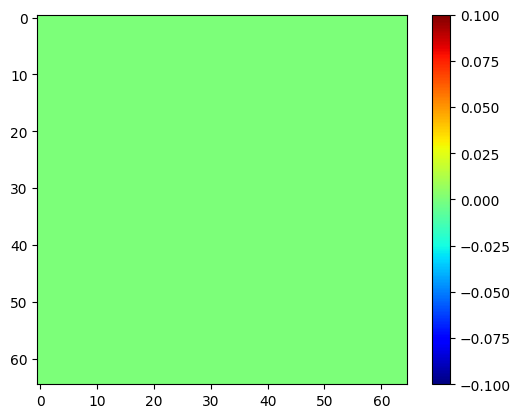

In [57]:
import cv2
path = '/data/real-circuit-benchmarks/asap7/numpy_data/dynamic'
resi = 'dynamic_node_voltage_map_regular.npy'

path = '/data/BeGAN-circuit-benchmarks/asap7/numpy_data/BeGAN/layer_data'
resi = 'current_map0998_m1_resistance.npy'

a = np.load(os.path.join(path,resi))
# a = cv2.resize(a.copy(),(512,512),interpolation=cv2.INTER_LANCZOS4)
print(a.min(),a.max(),a.shape)
plt.imshow(a,cmap='jet')
plt.colorbar()
plt.show()
# data = np.load(os.path.join('/'.join(path.split('/')[:-1]),'current_map50_current.npy')).shape
# data

In [70]:
a = np.load('/data/ICCAD_2023/fake-circuit-data_20230623/fake-circuit-data-npy/current_map50_current.npy')
a.shape

(771, 771)

In [19]:
a = pd.read_csv('/data/ICCAD_2023/fake-circuit-data_20230623/fake-circuit-data/current_map50_current.csv',header=None)
a.shape

(771, 771)

In [21]:
import gzip
import re

def parse_spice_file_one(file_path):
    """
    Reads a compressed SPICE (.sp.gz) file and parses the resistance data.

    Args:
    - file_path: Path to the .sp.gz file.

    Returns:
    - A list of dictionaries containing parsed data with keys:
      - 'node1': Starting node coordinates (tuple of x, y)
      - 'node2': Ending node coordinates (tuple of x, y)
      - 'resistance': Resistance value between the nodes
      - 'layer': Layer name if specified in the file
    """
    parsed_data = []

    with gzip.open(file_path, 'rt') as file:
        for line in file:
            # Match resistance lines with format like: R645 n1_m1_108000_17920 n1_m1_102600_179200 0.14
            match = re.match(r"R\d+\s+n1_(\w+)_(\d+)_(\d+)\s+n1_(\w+)_(\d+)_(\d+)\s+([\d.]+)", line)
            if match:
                # Extract the layer and coordinate information
                layer1 = match.group(1)
                layer2 = match.group(4)
                x1, y1 = int(match.group(2)), int(match.group(3))
                x2, y2 = int(match.group(5)), int(match.group(6))
                resistance = float(match.group(7))

                # Add parsed information to list
                parsed_data.append({
                    'node1': (x1, y1),
                    'node2': (x2, y2),
                    'resistance': resistance,
                    'layer': layer1 if layer1 == layer2 else f"{layer1}-{layer2}"
                })

    return parsed_data


In [49]:
path = '/data/BeGAN-circuit-benchmarks/asap7/data'
name = 'BeGAN_497_reg_grid.sp.gz'

parsed = parse_spice_file_one(os.path.join(path,name))

for entry in parsed:  # 첫 5개 데이터만 출력
    if entry['layer'] == 'M7-M8':
        print(entry)

{'node1': (60, 60), 'node2': (60, 60), 'resistance': 10.0, 'layer': 'M7-M8'}
{'node1': (60, 6460), 'node2': (60, 6460), 'resistance': 10.0, 'layer': 'M7-M8'}
{'node1': (60, 12860), 'node2': (60, 12860), 'resistance': 10.0, 'layer': 'M7-M8'}
{'node1': (60, 19260), 'node2': (60, 19260), 'resistance': 10.0, 'layer': 'M7-M8'}
{'node1': (60, 25660), 'node2': (60, 25660), 'resistance': 10.0, 'layer': 'M7-M8'}
{'node1': (60, 32060), 'node2': (60, 32060), 'resistance': 10.0, 'layer': 'M7-M8'}
{'node1': (60, 38460), 'node2': (60, 38460), 'resistance': 10.0, 'layer': 'M7-M8'}
{'node1': (60, 44860), 'node2': (60, 44860), 'resistance': 10.0, 'layer': 'M7-M8'}
{'node1': (60, 51260), 'node2': (60, 51260), 'resistance': 10.0, 'layer': 'M7-M8'}
{'node1': (60, 57660), 'node2': (60, 57660), 'resistance': 10.0, 'layer': 'M7-M8'}
{'node1': (60, 64060), 'node2': (60, 64060), 'resistance': 10.0, 'layer': 'M7-M8'}
{'node1': (60, 70460), 'node2': (60, 70460), 'resistance': 10.0, 'layer': 'M7-M8'}
{'node1': (6

In [6]:
df = pd.DataFrame(parsed)
df.head()

,node1,node2,resistance,layer
0,"(0, 0)","(1080, 0)",0.9882,M2
1,"(1080, 0)","(2160, 0)",0.9882,M2
2,"(2160, 0)","(3240, 0)",0.9882,M2
3,"(3240, 0)","(4320, 0)",0.9882,M2
4,"(4320, 0)","(5400, 0)",0.9882,M2


<Axes: >

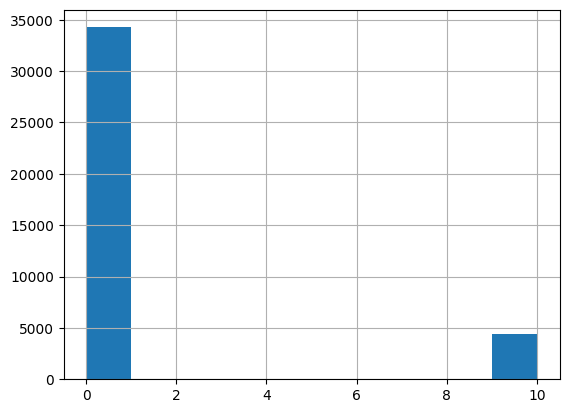

In [7]:
df['resistance'].hist()

In [12]:
import os
import shutil

# 폴더 옮기기 (layer_Data)
def restructure_layer_data(root_dir):
    # Define paths
    numpy_data_dir = os.path.join(root_dir, "numpy_data")
    layer_data_dir = os.path.join(numpy_data_dir, "layer_data")
    
    # Check if layer_data directory exists
    if not os.path.exists(layer_data_dir):
        print("layer_data directory does not exist.")
        return

    # Get all folders in layer_data directory
    subfolders = [f for f in os.listdir(layer_data_dir) if os.path.isdir(os.path.join(layer_data_dir, f))]

    for subfolder in subfolders:
        # Define the target layer_data path inside each main folder
        target_layer_data_dir = os.path.join(numpy_data_dir, subfolder, "layer_data")
        os.makedirs(target_layer_data_dir, exist_ok=True)
        
        # Source path for current subfolder's layer data
        source_folder = os.path.join(layer_data_dir, subfolder)

        # Move all files from layer_data/subfolder to numpy_data/subfolder/layer_data
        for item in os.listdir(source_folder):
            source_path = os.path.join(source_folder, item)
            target_path = os.path.join(target_layer_data_dir, item)
            if os.path.isfile(source_path):
                shutil.move(source_path, target_path)
                print(f"Moved {source_path} to {target_path}")

    # Optionally, remove the now-empty layer_data directory
    shutil.rmtree(layer_data_dir)
    print("Restructuring complete. Removed the old layer_data directory.")

# # 실행 예시
# root_dir = '/data/real-circuit-benchmarks/nangate45'
# restructure_layer_data(root_dir)


Moved /data/real-circuit-benchmarks/nangate45/numpy_data/layer_data/dynamic/m89_resistance_matrix.npy to /data/real-circuit-benchmarks/nangate45/numpy_data/dynamic/layer_data/m89_resistance_matrix.npy
Moved /data/real-circuit-benchmarks/nangate45/numpy_data/layer_data/dynamic/m78_resistance_matrix.npy to /data/real-circuit-benchmarks/nangate45/numpy_data/dynamic/layer_data/m78_resistance_matrix.npy
Moved /data/real-circuit-benchmarks/nangate45/numpy_data/layer_data/dynamic/m4_resistance_matrix.npy to /data/real-circuit-benchmarks/nangate45/numpy_data/dynamic/layer_data/m4_resistance_matrix.npy
Moved /data/real-circuit-benchmarks/nangate45/numpy_data/layer_data/dynamic/m9_resistance_matrix.npy to /data/real-circuit-benchmarks/nangate45/numpy_data/dynamic/layer_data/m9_resistance_matrix.npy
Moved /data/real-circuit-benchmarks/nangate45/numpy_data/layer_data/dynamic/m14_resistance_matrix.npy to /data/real-circuit-benchmarks/nangate45/numpy_data/dynamic/layer_data/m14_resistance_matrix.npy

['m89_resistance_matrix.npy', 'm78_resistance_matrix.npy', 'm4_resistance_matrix.npy', 'm9_resistance_matrix.npy', 'm14_resistance_matrix.npy', 'm7_resistance_matrix.npy', 'm1_resistance_matrix.npy', 'm47_resistance_matrix.npy', 'm8_resistance_matrix.npy']


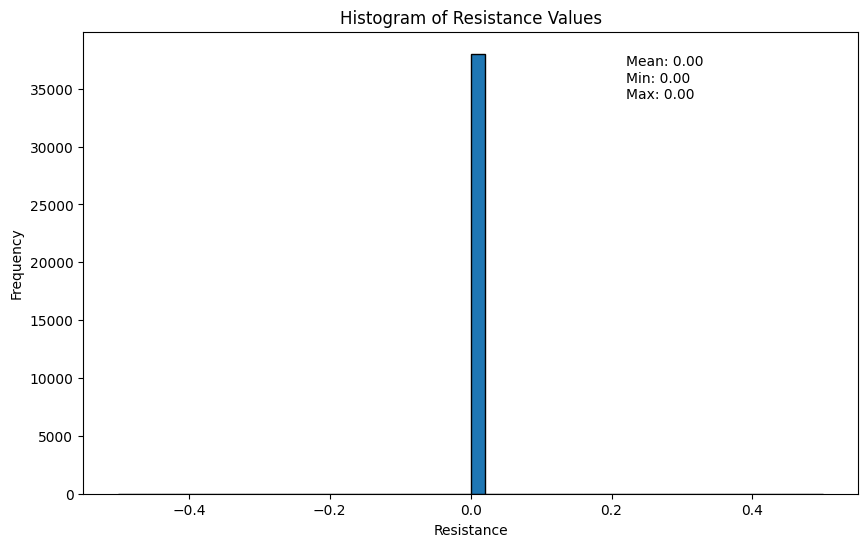

Mean: 0.0
Min: 0.0
Max: 0.0


In [82]:
import os
import numpy as np
import matplotlib.pyplot as plt

def analyze_resistance_matrices(folder_path):
    # 폴더 내의 모든 .npy 파일 찾기
    npy_files = [f for f in os.listdir(folder_path) if f.endswith('_resistance_matrix.npy')]
    print(npy_files)
    all_data = []
    
    for file in npy_files:
        file_path = os.path.join(folder_path, file)
        data = np.load(file_path)
        all_data.append(data.flatten())  # 2D 배열을 1D로 평탄화
    
    # 모든 데이터를 하나의 배열로 합치기
    all_data = np.concatenate(all_data)
    
    # 통계 계산
    mean_value = np.mean(all_data)
    min_value = np.min(all_data)
    max_value = np.max(all_data)
    
    # 히스토그램 그리기
    plt.figure(figsize=(10, 6))
    plt.hist(all_data, bins=50, edgecolor='black')
    plt.title('Histogram of Resistance Values')
    plt.xlabel('Resistance')
    plt.ylabel('Frequency')
    
    # 통계 정보 추가
    plt.text(0.7, 0.95, f'Mean: {mean_value:.2f}\nMin: {min_value:.2f}\nMax: {max_value:.2f}', 
             transform=plt.gca().transAxes, verticalalignment='top')
    
    plt.show()
    
    return mean_value, min_value, max_value

# 함수 사용 예시
folder_path = '/data/real-circuit-benchmarks/asap7/numpy_data/dynamic/layer_data/reg'
mean, min_val, max_val = analyze_resistance_matrices(folder_path)

print(f"Mean: {mean}")
print(f"Min: {min_val}")
print(f"Max: {max_val}")

Checking shapes for process: aes
  aes_current_map.csv.gz shape: (85, 85)
  aes_voltage_map_regular.csv.gz shape: (82, 82)
  aes_voltage_map_irregular.csv.gz shape: (85, 85)


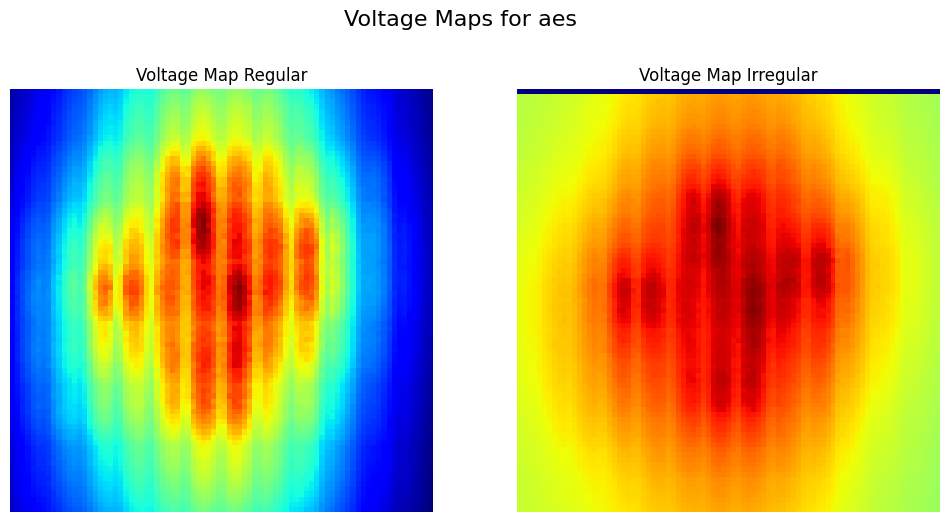

--------------------------------------------------
Checking shapes for process: dynamic_node
  dynamic_node_current_map.csv.gz shape: (65, 65)
  dynamic_node_voltage_map_regular.csv.gz shape: (62, 62)
  dynamic_node_voltage_map_irregular.csv.gz shape: (65, 65)


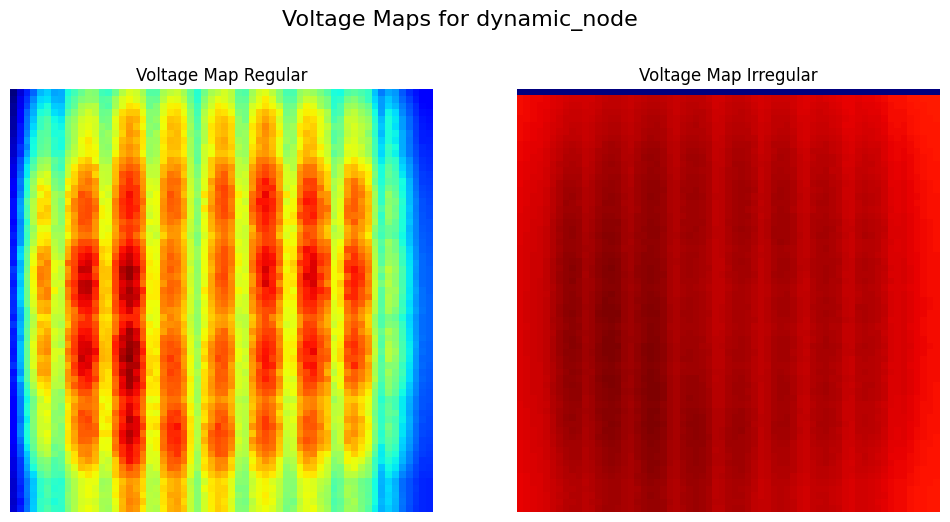

--------------------------------------------------
Checking shapes for process: ibex
  ibex_current_map.csv.gz shape: (74, 74)
  ibex_voltage_map_regular.csv.gz shape: (71, 71)
  ibex_voltage_map_irregular.csv.gz shape: (74, 74)


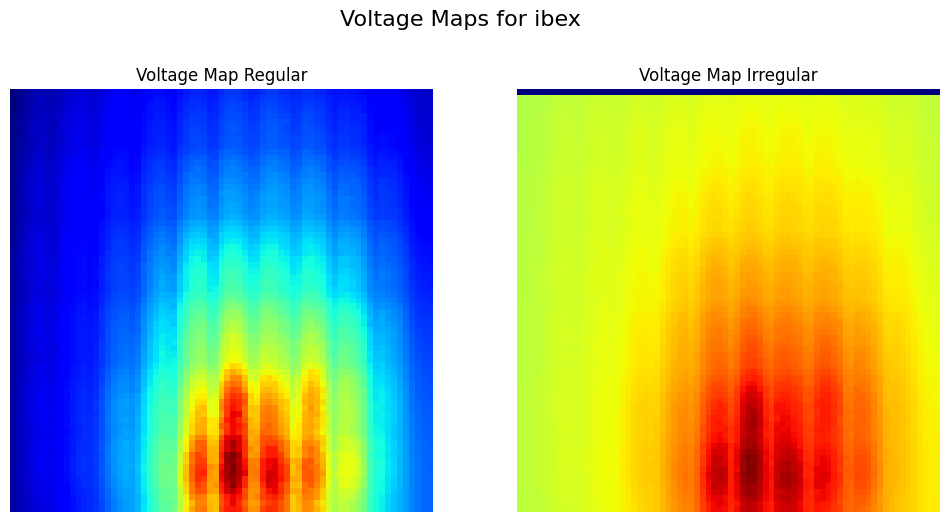

--------------------------------------------------
Checking shapes for process: jpeg
  jpeg_current_map.csv.gz shape: (127, 127)
  jpeg_voltage_map_regular.csv.gz shape: (124, 124)
  jpeg_voltage_map_irregular.csv.gz shape: (127, 127)


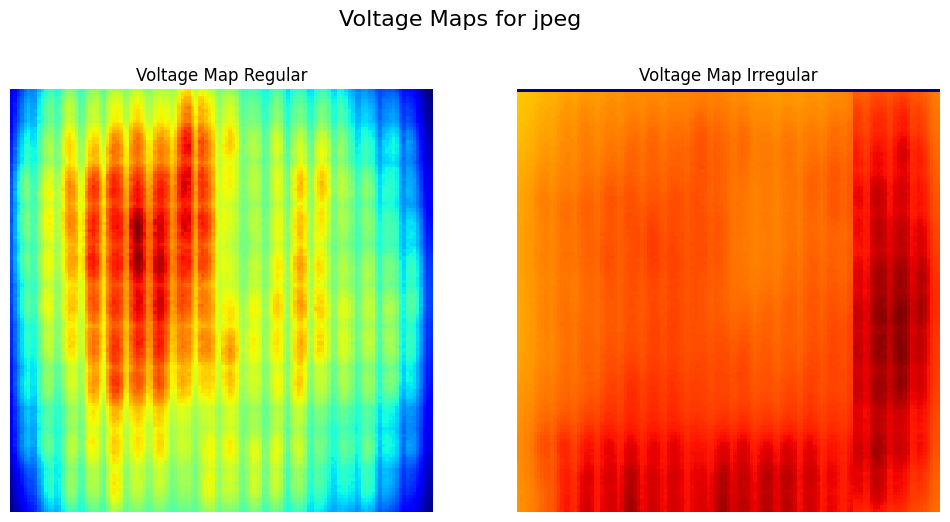

--------------------------------------------------


In [81]:
import gzip
import pandas as pd
import os
import matplotlib.pyplot as plt

def check_and_visualize_shapes(root_path, process_names):
    """
    Check shape consistency and visualize voltage_map_regular and voltage_map_irregular for each process.

    Args:
        root_path (str): The directory containing the data files.
        process_names (list): List of process names (e.g., ['aes', 'ibex', 'jpeg', 'dynamic_node']).
    """
    for process in process_names:
        print(f"Checking shapes for process: {process}")

        # Define file paths
        current_map_path = os.path.join(root_path, f"{process}_current_map.csv.gz")
        voltage_map_regular_path = os.path.join(root_path, f"{process}_voltage_map_regular.csv.gz")
        voltage_map_irregular_path = os.path.join(root_path, f"{process}_voltage_map_irregular.csv.gz")

        # Load files and check shapes
        try:
            with gzip.open(current_map_path, 'rt') as f:
                current_map = pd.read_csv(f, header=None)
            current_shape = current_map.shape
            print(f"  {process}_current_map.csv.gz shape: {current_shape}")

            with gzip.open(voltage_map_regular_path, 'rt') as f:
                voltage_map_regular = pd.read_csv(f, header=None)
            regular_shape = voltage_map_regular.shape
            print(f"  {process}_voltage_map_regular.csv.gz shape: {regular_shape}")

            with gzip.open(voltage_map_irregular_path, 'rt') as f:
                voltage_map_irregular = pd.read_csv(f, header=None)
            irregular_shape = voltage_map_irregular.shape
            print(f"  {process}_voltage_map_irregular.csv.gz shape: {irregular_shape}")

            # Check for consistency
            if current_shape != regular_shape:
                print(f"Warning: Shape mismatch between current_map and voltage_map_regular for {process}")
            if current_shape != irregular_shape:
                print(f"Warning: Shape mismatch between current_map and voltage_map_irregular for {process}")

            # Visualization
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            fig.suptitle(f"Voltage Maps for {process}", fontsize=16)

            # Plot regular map
            axes[0].imshow(voltage_map_regular, cmap='jet')
            axes[0].set_title("Voltage Map Regular")
            axes[0].axis('off')

            # Plot irregular map
            axes[1].imshow(voltage_map_irregular, cmap='jet')
            axes[1].set_title("Voltage Map Irregular")
            axes[1].axis('off')

            plt.show()

        except FileNotFoundError as e:
            print(f"Error: {e}")
        except Exception as e:
            print(f"Error loading data for {process}: {e}")
        print("-" * 50)

# Example usage
root_path = "/data/real-circuit-benchmarks/asap7/data"
process_names = ["aes", "dynamic_node", "ibex", "jpeg"]
check_and_visualize_shapes(root_path, process_names)
